In [1]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv("normal_GPS.csv")
df = df[['id', 'lon', 'lat', 'est']]
df['Label'] = 0
df.to_csv("normaldata.csv", index=False)

In [3]:
df = pd.read_csv("abnormal_GPS.csv")
df = df[['id', 'lon', 'lat', 'est']]
df['Label'] = 1
df.to_csv("abnormaldata.csv", index=False)
df

id       lon       lat  \
0       e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06923  26.37656   
1       e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06926  26.37668   
2       e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06926  26.37673   
3       e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06926  26.37678   
4       e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06926  26.37683   
...                                      ...       ...       ...   
327327  e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06912  26.37681   
327328  e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06914  26.37682   
327329  e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06916  26.37682   
327330  e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06920  26.37683   
327331  e157f7aa-206c-46a7-b35d-3026bcdccca8 -80.06923  26.37683   

                                 est  Label  
0       '2023-02-01 06:00:21.208994'      1  
1       '2023-02-01 06:00:22.307296'      1  
2       '2023-02-01 06:00:23.348163'      1  
3       '2023-02-01 06:00:24.381662'      1  
4       '2023-02-01 06:00:25.420965'      1  
...                              ...    ...  
327327  '2023-02-28 17:10:02.449788'      1  
327328  '2023-02-28 17:10:03.491318'      1  
327329  '2023-02-28 17:10:04.527795'      1  
327330  '2023-02-28 17:10:05.568912'      1  
327331  '2023-02-28 17:10:06.663096'      1  

[327332 rows x 5 columns]

In [4]:
# Load the datasets
normal_df = pd.read_csv("normaldata.csv")
abnormal_df = pd.read_csv("abnormaldata.csv")

# Combine the datasets
df = pd.concat([normal_df, abnormal_df], ignore_index=True)

In [5]:
df = df[['id', 'lon', 'lat', 'est', 'Label']]
pd.options.mode.copy_on_write = True
df['est'] = pd.to_datetime(df['est'])
# Sort by the timestamp
df.sort_values('est', inplace=True)
df['Date'] = df['est'].dt.date

In [6]:
# Ensure 'est' is in datetime format
df['est'] = pd.to_datetime(df['est'])

# Calculate time differences between consecutive points
df['time_diff'] = df['est'].diff().fillna(pd.Timedelta(seconds=0))

gap_threshold = pd.Timedelta(minutes=1)

# Identify where a new trip starts
df['new_trip'] = df['time_diff'] > gap_threshold

# Assign trip IDs
df['trip_id'] = df['new_trip'].cumsum()

# Optionally, drop helper columns if not needed
df.drop(columns=['time_diff', 'new_trip'], inplace=True)
df

id       lon       lat  \
0       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09731  26.47975   
1       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
2       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
3       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
4       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47973   
...                                      ...       ...       ...   
922569  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922570  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922571  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922572  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922573  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   

                              est  Label        Date  trip_id  
0      2023-01-25 14:45:06.007579      0  2023-01-25        0  
1      2023-01-25 14:45:07.140520      0  2023-01-25        0  
2      2023-01-25 14:45:08.172373      0  2023-01-25        0  
3      2023-01-25 14:45:09.206060      0  2023-01-25        0  
4      2023-01-25 14:45:12.857343      0  2023-01-25        0  
...                           ...    ...         ...      ...  
922569 2023-11-29 14:27:40.723326      0  2023-11-29      664  
922570 2023-11-29 14:27:41.766899      0  2023-11-29      664  
922571 2023-11-29 14:27:42.812880      0  2023-11-29      664  
922572 2023-11-29 14:27:43.850681      0  2023-11-29      664  
922573 2023-11-29 14:27:44.883588      0  2023-11-29      664  

[1249906 rows x 7 columns]

In [7]:
import pandas as pd
from geopy.distance import geodesic

def calculate_segments(df, threshold=1000):
    # Initialize the segment counter
    df['Segment'] = 0
    segment_counter = 0
    
    # Group by 'trip_id' and iterate over each group
    for trip_id, group in df.groupby('trip_id'):
        segment_distance = 0
        start_index = group.index[0]  # Get the start index of the group
        df.at[start_index, 'Segment'] = segment_counter  # Assign the segment number to the first point
        
        # Iterate over the group rows
        for i in range(1, len(group)):
            # Calculate distance from the current point to the previous point
            distance = geodesic(
                (group.iloc[i - 1]['lat'], group.iloc[i - 1]['lon']),
                (group.iloc[i]['lat'], group.iloc[i]['lon'])
            ).meters
            
            segment_distance += distance  # Accumulate the distance
            
            # If the segment distance exceeds the threshold, increment the segment counter
            if segment_distance >= threshold:
                segment_distance = 0  # Reset segment distance
                segment_counter += 1  # Increment segment counter
            
            # Assign the segment number
            current_index = group.index[i]
            df.at[current_index, 'Segment'] = segment_counter
        
        segment_counter += 1  # Increment the segment counter for the next trip
    
    return df

# Your existing DataFrame loading and trip calculation code here...

# Now, apply the calculate_segments function to segment each trip into 1km segments
df = calculate_segments(df, threshold=1000)

In [8]:
df.to_csv("Novelty_dataset.csv", index=False)

In [9]:
# Constants for padding
DESIRED_LENGTH = 137
mean_values = df[['lon', 'lat']].mean().to_dict()

# Function to process each segment
def process_segment(segment):
    len_diff = DESIRED_LENGTH - len(segment)
    if len_diff > 0:  # Pad
        padding = pd.DataFrame([mean_values] * len_diff)
        for col in ['id', 'Date', 'Label', 'trip_id', 'Segment']:
            padding[col] = segment[col].iloc[0]
        segment = pd.concat([segment, padding], ignore_index=True)
    elif len_diff < 0:  # Trim
        segment = segment.iloc[:DESIRED_LENGTH]
    return segment

# Processing segments
processed_segments = [process_segment(group) for _, group in df.groupby('Segment')]

# Reconstructing the DataFrame
processed_df = pd.concat(processed_segments, ignore_index=True)

# Verifying the process
print(processed_df.groupby('Segment').size())

Segment
0         137
1         137
2         137
3         137
4         137
         ... 
104582    137
104583    137
104584    137
104585    137
104586    137
Length: 104587, dtype: int64


In [10]:
processed_df.to_csv("Novelty_dataset.csv", index=False)

In [11]:
# Constants for the calculations
EARTH_RADIUS_KM = 6371.0088
LAT_DEGREE_IN_KM = 110.574
LON_DEGREE_IN_KM = 111.320 * np.cos(np.radians(26.47975))  # Average latitude for South Florida

# Function to calculate the distance in meters
def calculate_distance(lat1, lon1, lat2, lon2):
    delta_lat_km = (lat2 - lat1) * LAT_DEGREE_IN_KM
    delta_lon_km = (lon2 - lon1) * LON_DEGREE_IN_KM
    return delta_lat_km * 1000, delta_lon_km * 1000

# Define the grid size in meters
grid_size = 1000  # 1 km grid cells

# Initialize empty lists to store computed values
x_m = []
y_m = []
grid_x = []
grid_y = []

# Iterate through the DataFrame by trip_id
for trip_id in df['trip_id'].unique():
    trip_data = df[df['trip_id'] == trip_id]
    origin_lat = trip_data.iloc[0]['lat']
    origin_lon = trip_data.iloc[0]['lon']
    
    for _, row in trip_data.iterrows():
        distance_x, distance_y = calculate_distance(origin_lat, origin_lon, row['lat'], row['lon'])
        x_m.append(distance_x)
        y_m.append(distance_y)
        grid_x.append(np.floor(distance_x / grid_size).astype(int))
        grid_y.append(np.floor(distance_y / grid_size).astype(int))

# Assign calculated values back to the DataFrame
df['x_m'] = x_m
df['y_m'] = y_m
df['grid_x'] = grid_x
df['grid_y'] = grid_y
df['grid_x_km'] = df['grid_x']
df['grid_y_km'] = df['grid_y']

In [12]:
# Convert the meter indices to kilometers by dividing by 1000
df['grid_x_km'] = df['grid_x']
df['grid_y_km'] = df['grid_y']

# Function to visualize a single trip
def plot_trip(trip_id, dataframe):
    trip_data = dataframe[dataframe['trip_id'] == trip_id]
    plt.figure(figsize=(8, 6))
    
    
    # Determine the bounds of the trip data
    x_min, x_max = trip_data['x_m'].min(), trip_data['x_m'].max()
    y_min, y_max = trip_data['y_m'].min(), trip_data['y_m'].max()

    # Expand the bounds to the nearest grid lines
    x_min, x_max = (np.floor(x_min / grid_size) * grid_size, np.ceil(x_max / grid_size) * grid_size)
    y_min, y_max = (np.floor(y_min / grid_size) * grid_size, np.ceil(y_max / grid_size) * grid_size)

    # Generate grid lines within the bounds
    grid_lines_x = np.arange(x_min, x_max + grid_size, grid_size)
    grid_lines_y = np.arange(y_min, y_max + grid_size, grid_size)

    # Plot vertical grid lines
    for x in grid_lines_x:
        plt.axvline(x, color='lightgrey', lw=0.5)

    # Plot horizontal grid lines
    for y in grid_lines_y:
        plt.axhline(y, color='lightgrey', lw=0.5)

    # Plot the trip points
    plt.scatter(trip_data['x_m'], trip_data['y_m'], c='blue', label='Trip Points')
    plt.scatter(0, 0, c='red', label='Start (0,0)')

    plt.title(f'Trip ID 1 Grid Overlay')
    plt.xlabel('Distance East-West (m)')
    plt.ylabel('Distance North-South (m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(x_min - grid_size, x_max + grid_size)
    plt.ylim(y_min - grid_size, y_max + grid_size)
    plt.show()

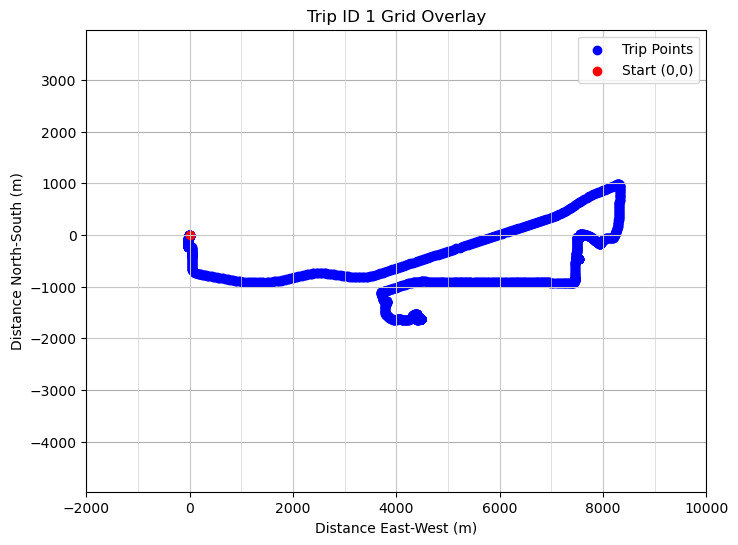

In [13]:
import matplotlib.pyplot as plt
# Plot a single trip by trip_id
plot_trip(1, df)

In [14]:
df = df[['id', 'lon', 'lat', 'est', 'grid_x', 'grid_y', 'Segment','trip_id', 'Label']]
df.to_csv('Novelty_dataset.csv', index=False)
df

id       lon       lat  \
0       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09731  26.47975   
1       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
2       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
3       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
4       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47973   
...                                      ...       ...       ...   
922569  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922570  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922571  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922572  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922573  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   

                              est  grid_x  grid_y  Segment  trip_id  Label  
0      2023-01-25 14:45:06.007579       0       0        0        0      0  
1      2023-01-25 14:45:07.140520      -1       0        0        0      0  
2      2023-01-25 14:45:08.172373      -1       0        0        0      0  
3      2023-01-25 14:45:09.206060      -1       0        0        0      0  
4      2023-01-25 14:45:12.857343      -1       0        0        0      0  
...                           ...     ...     ...      ...      ...    ...  
922569 2023-11-29 14:27:40.723326     -13      -9   104586      664      0  
922570 2023-11-29 14:27:41.766899     -13      -9   104586      664      0  
922571 2023-11-29 14:27:42.812880     -13      -9   104586      664      0  
922572 2023-11-29 14:27:43.850681     -13      -9   104586      664      0  
922573 2023-11-29 14:27:44.883588     -13      -9   104586      664      0  

[1249906 rows x 9 columns]

In [15]:
# Constants for the calculations
EARTH_RADIUS_KM = 6371.0088
LAT_DEGREE_IN_KM = 110.574
LON_DEGREE_IN_KM = 111.320 * np.cos(np.radians(26.47975))  # Average latitude for South Florida
# Define the grid size in meters
grid_size = 1000  # 1 km grid cells

# Function to rotate coordinates by 90 degrees
def rotate_90(lat, lon):
    # Assuming rotation around the origin (first point), we need to translate points
    translated_lat = lat - lat.iloc[0]
    translated_lon = lon - lon.iloc[0]

    # Convert to radians for rotation
    translated_lat_rad = np.radians(translated_lat)
    translated_lon_rad = np.radians(translated_lon)

    # Rotate by 90 degrees: x' = -y, y' = x
    rotated_lat_rad = -translated_lon_rad
    rotated_lon_rad = translated_lat_rad

    # Convert back to degrees
    rotated_lat = np.degrees(rotated_lat_rad) + lat.iloc[0]
    rotated_lon = np.degrees(rotated_lon_rad) + lon.iloc[0]

    return rotated_lat, rotated_lon

# Apply rotation to each trip and calculate distances in meters
for trip_id in df['trip_id'].unique():
    trip_data = df[df['trip_id'] == trip_id].copy()
    rotated_lat, rotated_lon = rotate_90(trip_data['lat'], trip_data['lon'])

    # Apply the distance calculation
    trip_data['rotated_x_m'], trip_data['rotated_y_m'] = calculate_distance(
        trip_data.iloc[0]['lat'], trip_data.iloc[0]['lon'], rotated_lat, rotated_lon)

    # Calculate the grid indices
    trip_data['aug90_grid_x'] = np.floor(trip_data['rotated_x_m'] / grid_size).astype(int)
    trip_data['aug90_grid_y'] = np.floor(trip_data['rotated_y_m'] / grid_size).astype(int)

    # Update the main dataframe
    df.loc[trip_data.index, 'aug90_x_m'] = trip_data['rotated_x_m']
    df.loc[trip_data.index, 'aug90_y_m'] = trip_data['rotated_y_m']
    df.loc[trip_data.index, 'aug90_grid_x'] = trip_data['aug90_grid_x']
    df.loc[trip_data.index, 'aug90_grid_y'] = trip_data['aug90_grid_y']

In [16]:
import matplotlib.pyplot as plt
def plot_rotated_trip(df, trip_id, grid_size=1000):
    trip_data = df[df['trip_id'] == trip_id]
    plt.figure(figsize=(8, 6))

    # Determine the bounds of the trip data
    x_min, x_max = trip_data['aug90_x_m'].min(), trip_data['aug90_x_m'].max()
    y_min, y_max = trip_data['aug90_y_m'].min(), trip_data['aug90_y_m'].max()

    # Expand the bounds to the nearest grid lines
    x_min, x_max = (np.floor(x_min / grid_size) * grid_size, np.ceil(x_max / grid_size) * grid_size)
    y_min, y_max = (np.floor(y_min / grid_size) * grid_size, np.ceil(y_max / grid_size) * grid_size)

    # Generate grid lines within the bounds
    grid_lines_x = np.arange(x_min, x_max + grid_size, grid_size)
    grid_lines_y = np.arange(y_min, y_max + grid_size, grid_size)

    # Plot vertical grid lines
    for x in grid_lines_x:
        plt.axvline(x, color='lightgrey', lw=0.5)

    # Plot horizontal grid lines
    for y in grid_lines_y:
        plt.axhline(y, color='lightgrey', lw=0.5)

    # Plot the trip points
    plt.scatter(trip_data['aug90_x_m'], trip_data['aug90_y_m'], c='blue', label='Augmented 90° Trip Points')
    plt.scatter(0, 0, c='red', label='Start (0,0)')

    plt.title(f'Trip ID {trip_id} Augmented at 90°')
    plt.xlabel('Distance East-West (m)')
    plt.ylabel('Distance North-South (m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(x_min - grid_size, x_max + grid_size)
    plt.ylim(y_min - grid_size, y_max + grid_size)
    plt.show()

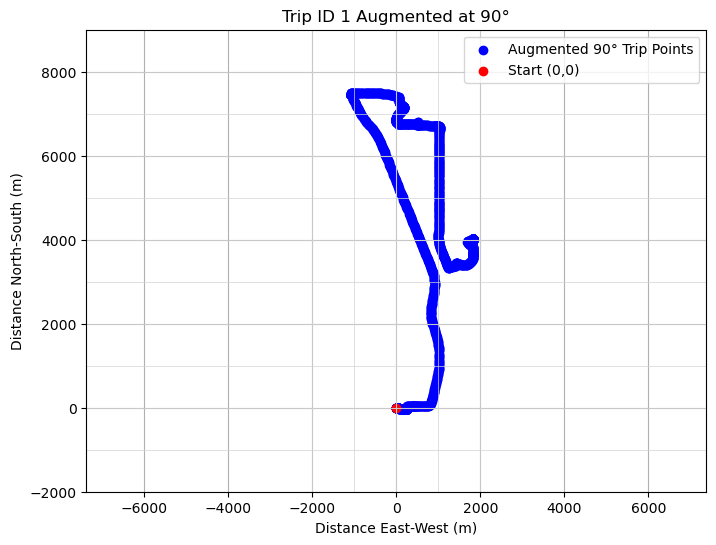

In [17]:
# Example usage
plot_rotated_trip(df, 1, grid_size=1000)

In [18]:
df = df[['id', 'lon', 'lat', 'est', 'grid_x', 'grid_y', 'aug90_grid_x', 'aug90_grid_y','Segment','trip_id', 'Label']]
df.to_csv('Novelty_dataset.csv', index=False)
df

id       lon       lat  \
0       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09731  26.47975   
1       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
2       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
3       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
4       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47973   
...                                      ...       ...       ...   
922569  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922570  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922571  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922572  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922573  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   

                              est  grid_x  grid_y  aug90_grid_x  aug90_grid_y  \
0      2023-01-25 14:45:06.007579       0       0           0.0           0.0   
1      2023-01-25 14:45:07.140520      -1       0          -1.0          -1.0   
2      2023-01-25 14:45:08.172373      -1       0          -1.0          -1.0   
3      2023-01-25 14:45:09.206060      -1       0          -1.0          -1.0   
4      2023-01-25 14:45:12.857343      -1       0          -1.0          -1.0   
...                           ...     ...     ...           ...           ...   
922569 2023-11-29 14:27:40.723326     -13      -9           9.0         -11.0   
922570 2023-11-29 14:27:41.766899     -13      -9           9.0         -11.0   
922571 2023-11-29 14:27:42.812880     -13      -9           9.0         -11.0   
922572 2023-11-29 14:27:43.850681     -13      -9           9.0         -11.0   
922573 2023-11-29 14:27:44.883588     -13      -9           9.0         -11.0   

        Segment  trip_id  Label  
0             0        0      0  
1             0        0      0  
2             0        0      0  
3             0        0      0  
4             0        0      0  
...         ...      ...    ...  
922569   104586      664      0  
922570   104586      664      0  
922571   104586      664      0  
922572   104586      664      0  
922573   104586      664      0  

[1249906 rows x 11 columns]

In [19]:
# Function to rotate coordinates by 180 degrees
def rotate_180(lat, lon):
    # Assuming rotation around the origin (first point), we need to translate points
    translated_lat = lat - lat.iloc[0]
    translated_lon = lon - lon.iloc[0]

    # Rotate by 180 degrees: x' = -x, y' = -y
    rotated_lat = -translated_lat + lat.iloc[0]
    rotated_lon = -translated_lon + lon.iloc[0]

    return rotated_lat, rotated_lon

# Apply rotation to each trip and calculate distances in meters
for trip_id in df['trip_id'].unique():
    trip_data = df[df['trip_id'] == trip_id].copy()
    rotated_lat, rotated_lon = rotate_180(trip_data['lat'], trip_data['lon'])

    # Apply the distance calculation
    trip_data['rotated_x_m'], trip_data['rotated_y_m'] = calculate_distance(
        trip_data.iloc[0]['lat'], trip_data.iloc[0]['lon'], rotated_lat, rotated_lon)

    # Calculate the grid indices
    trip_data['aug180_grid_x'] = np.floor(trip_data['rotated_x_m'] / grid_size).astype(int)
    trip_data['aug180_grid_y'] = np.floor(trip_data['rotated_y_m'] / grid_size).astype(int)

    # Update the main dataframe
    df.loc[trip_data.index, 'aug180_x_m'] = trip_data['rotated_x_m']
    df.loc[trip_data.index, 'aug180_y_m'] = trip_data['rotated_y_m']
    df.loc[trip_data.index, 'aug180_grid_x'] = trip_data['aug180_grid_x']
    df.loc[trip_data.index, 'aug180_grid_y'] = trip_data['aug180_grid_y']

In [20]:
import matplotlib.pyplot as plt
def plot_rotated_trip(df, trip_id, grid_size=1000):
    trip_data = df[df['trip_id'] == trip_id]
    plt.figure(figsize=(8, 6))

    # Determine the bounds of the trip data
    x_min, x_max = trip_data['aug180_x_m'].min(), trip_data['aug180_x_m'].max()
    y_min, y_max = trip_data['aug180_y_m'].min(), trip_data['aug180_y_m'].max()

    # Expand the bounds to the nearest grid lines
    x_min, x_max = (np.floor(x_min / grid_size) * grid_size, np.ceil(x_max / grid_size) * grid_size)
    y_min, y_max = (np.floor(y_min / grid_size) * grid_size, np.ceil(y_max / grid_size) * grid_size)

    # Generate grid lines within the bounds
    grid_lines_x = np.arange(x_min, x_max + grid_size, grid_size)
    grid_lines_y = np.arange(y_min, y_max + grid_size, grid_size)

    # Plot vertical grid lines
    for x in grid_lines_x:
        plt.axvline(x, color='lightgrey', lw=0.5)

    # Plot horizontal grid lines
    for y in grid_lines_y:
        plt.axhline(y, color='lightgrey', lw=0.5)

    # Plot the trip points
    plt.scatter(trip_data['aug180_x_m'], trip_data['aug180_y_m'], c='blue', label='Augmented 180° Trip Points')
    plt.scatter(0, 0, c='red', label='Start (0,0)')

    plt.title(f'Trip ID {trip_id} Augmented at 180°')
    plt.xlabel('Distance East-West (m)')
    plt.ylabel('Distance North-South (m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(x_min - grid_size, x_max + grid_size)
    plt.ylim(y_min - grid_size, y_max + grid_size)
    plt.show()

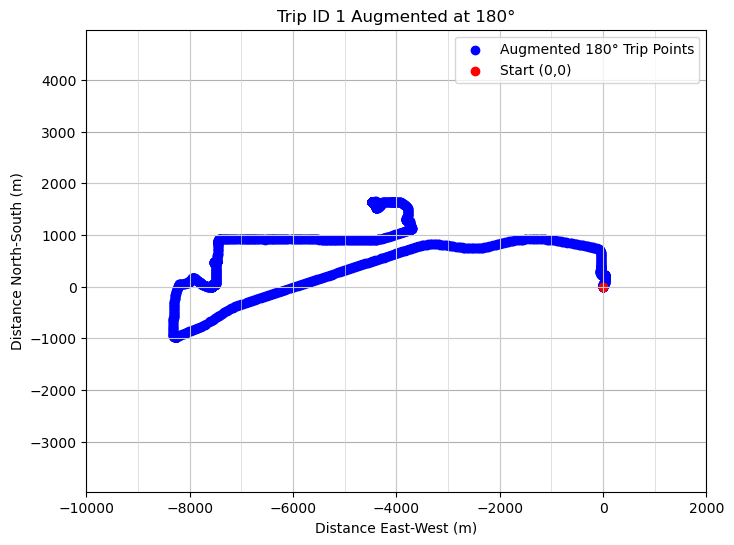

In [21]:
# Example usage
plot_rotated_trip(df, 1, grid_size=1000)

In [22]:
df = df[['id', 'lon', 'lat', 'est', 'grid_x', 'grid_y', 'aug90_grid_x', 'aug90_grid_y', 'aug180_grid_x', 'aug180_grid_y', 'Segment', 'trip_id', 'Label']]
df.to_csv('Novelty_dataset.csv', index=False)
df

id       lon       lat  \
0       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09731  26.47975   
1       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
2       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
3       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
4       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47973   
...                                      ...       ...       ...   
922569  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922570  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922571  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922572  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922573  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   

                              est  grid_x  grid_y  aug90_grid_x  aug90_grid_y  \
0      2023-01-25 14:45:06.007579       0       0           0.0           0.0   
1      2023-01-25 14:45:07.140520      -1       0          -1.0          -1.0   
2      2023-01-25 14:45:08.172373      -1       0          -1.0          -1.0   
3      2023-01-25 14:45:09.206060      -1       0          -1.0          -1.0   
4      2023-01-25 14:45:12.857343      -1       0          -1.0          -1.0   
...                           ...     ...     ...           ...           ...   
922569 2023-11-29 14:27:40.723326     -13      -9           9.0         -11.0   
922570 2023-11-29 14:27:41.766899     -13      -9           9.0         -11.0   
922571 2023-11-29 14:27:42.812880     -13      -9           9.0         -11.0   
922572 2023-11-29 14:27:43.850681     -13      -9           9.0         -11.0   
922573 2023-11-29 14:27:44.883588     -13      -9           9.0         -11.0   

        aug180_grid_x  aug180_grid_y  Segment  trip_id  Label  
0                 0.0            0.0        0        0      0  
1                 0.0           -1.0        0        0      0  
2                 0.0           -1.0        0        0      0  
3                 0.0           -1.0        0        0      0  
4                 0.0           -1.0        0        0      0  
...               ...            ...      ...      ...    ...  
922569           12.0            8.0   104586      664      0  
922570           12.0            8.0   104586      664      0  
922571           12.0            8.0   104586      664      0  
922572           12.0            8.0   104586      664      0  
922573           12.0            8.0   104586      664      0  

[1249906 rows x 13 columns]

In [23]:
pd.options.mode.copy_on_write = True
# Function to rotate coordinates by 270 degrees (-90 degrees)
def rotate_270(lat, lon):
    # Assuming rotation around the origin (first point), we need to translate points
    translated_lat = lat - lat.iloc[0]
    translated_lon = lon - lon.iloc[0]

    # Convert to radians for rotation
    translated_lat_rad = np.radians(translated_lat)
    translated_lon_rad = np.radians(translated_lon)

    # Rotate by -90 degrees: x' = y, y' = -x
    rotated_lat_rad = translated_lon_rad
    rotated_lon_rad = -translated_lat_rad

    # Convert back to degrees
    rotated_lat = np.degrees(rotated_lat_rad) + lat.iloc[0]
    rotated_lon = np.degrees(rotated_lon_rad) + lon.iloc[0]

    return rotated_lat, rotated_lon

# Apply rotation to each trip and calculate distances in meters
for trip_id in df['trip_id'].unique():
    trip_data = df[df['trip_id'] == trip_id].copy()
    rotated_lat, rotated_lon = rotate_270(trip_data['lat'], trip_data['lon'])

    # Apply the distance calculation
    trip_data['rotated_x_m'], trip_data['rotated_y_m'] = calculate_distance(
        trip_data.iloc[0]['lat'], trip_data.iloc[0]['lon'], rotated_lat, rotated_lon)

    # Calculate the grid indices
    trip_data['aug270_grid_x'] = np.floor(trip_data['rotated_x_m'] / grid_size).astype(int)
    trip_data['aug270_grid_y'] = np.floor(trip_data['rotated_y_m'] / grid_size).astype(int)

    # Update the main dataframe
    df.loc[trip_data.index, 'aug270_x_m'] = trip_data['rotated_x_m']
    df.loc[trip_data.index, 'aug270_y_m'] = trip_data['rotated_y_m']
    df.loc[trip_data.index, 'aug270_grid_x'] = trip_data['aug270_grid_x']
    df.loc[trip_data.index, 'aug270_grid_y'] = trip_data['aug270_grid_y']

In [24]:
import matplotlib.pyplot as plt
def plot_rotated_trip(df, trip_id, grid_size=1000):
    trip_data = df[df['trip_id'] == trip_id]
    plt.figure(figsize=(8, 6))

    # Determine the bounds of the trip data
    x_min, x_max = trip_data['aug270_x_m'].min(), trip_data['aug270_x_m'].max()
    y_min, y_max = trip_data['aug270_y_m'].min(), trip_data['aug270_y_m'].max()

    # Expand the bounds to the nearest grid lines
    x_min, x_max = (np.floor(x_min / grid_size) * grid_size, np.ceil(x_max / grid_size) * grid_size)
    y_min, y_max = (np.floor(y_min / grid_size) * grid_size, np.ceil(y_max / grid_size) * grid_size)

    # Generate grid lines within the bounds
    grid_lines_x = np.arange(x_min, x_max + grid_size, grid_size)
    grid_lines_y = np.arange(y_min, y_max + grid_size, grid_size)

    # Plot vertical grid lines
    for x in grid_lines_x:
        plt.axvline(x, color='lightgrey', lw=0.5)

    # Plot horizontal grid lines
    for y in grid_lines_y:
        plt.axhline(y, color='lightgrey', lw=0.5)

    # Plot the trip points
    plt.scatter(trip_data['aug270_x_m'], trip_data['aug270_y_m'], c='blue', label='Augmented 270° Trip Points')
    plt.scatter(0, 0, c='red', label='Start (0,0)')

    plt.title(f'Trip ID {trip_id} Augmented at 270°')
    plt.xlabel('Distance East-West (m)')
    plt.ylabel('Distance North-South (m)')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.xlim(x_min - grid_size, x_max + grid_size)
    plt.ylim(y_min - grid_size, y_max + grid_size)
    plt.show()

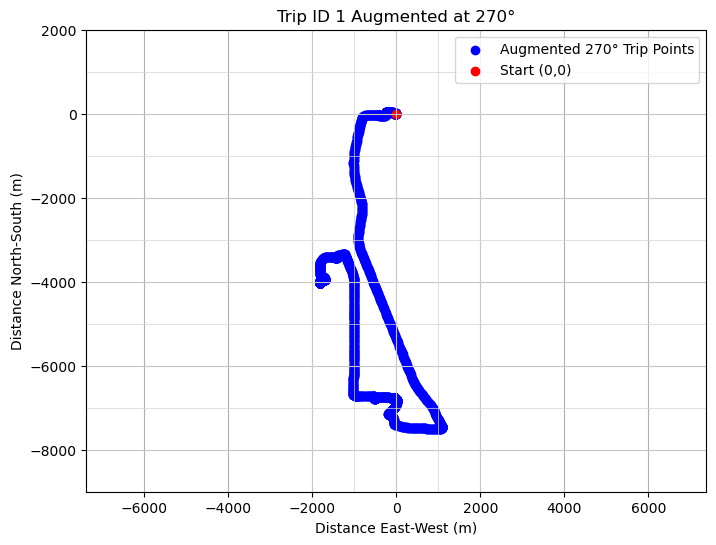

In [25]:
# Example usage
plot_rotated_trip(df, 1, grid_size=1000)

In [26]:
df = df[['id', 'lon', 'lat', 'est', 'grid_x', 'grid_y', 'aug90_grid_x', 'aug90_grid_y', 'aug180_grid_x', 'aug180_grid_y', 'aug270_grid_x', 'aug270_grid_y', 'Segment', 'trip_id', 'Label']]
df.to_csv('Novelty_dataset.csv', index=False)
df

id       lon       lat  \
0       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09731  26.47975   
1       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
2       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
3       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47974   
4       21b4d22a-eefc-46f2-bc26-f8c8b81fcfa4 -80.09730  26.47973   
...                                      ...       ...       ...   
922569  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922570  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922571  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922572  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   
922573  0167a05e-680d-4f57-a2f0-a4a9106a3221 -81.32238  28.57901   

                              est  grid_x  grid_y  aug90_grid_x  aug90_grid_y  \
0      2023-01-25 14:45:06.007579       0       0           0.0           0.0   
1      2023-01-25 14:45:07.140520      -1       0          -1.0          -1.0   
2      2023-01-25 14:45:08.172373      -1       0          -1.0          -1.0   
3      2023-01-25 14:45:09.206060      -1       0          -1.0          -1.0   
4      2023-01-25 14:45:12.857343      -1       0          -1.0          -1.0   
...                           ...     ...     ...           ...           ...   
922569 2023-11-29 14:27:40.723326     -13      -9           9.0         -11.0   
922570 2023-11-29 14:27:41.766899     -13      -9           9.0         -11.0   
922571 2023-11-29 14:27:42.812880     -13      -9           9.0         -11.0   
922572 2023-11-29 14:27:43.850681     -13      -9           9.0         -11.0   
922573 2023-11-29 14:27:44.883588     -13      -9           9.0         -11.0   

        aug180_grid_x  aug180_grid_y  aug270_grid_x  aug270_grid_y  Segment  \
0                 0.0            0.0            0.0            0.0        0   
1                 0.0           -1.0            0.0            0.0        0   
2                 0.0           -1.0            0.0            0.0        0   
3                 0.0           -1.0            0.0            0.0        0   
4                 0.0           -1.0            0.0            0.0        0   
...               ...            ...            ...            ...      ...   
922569           12.0            8.0          -10.0           10.0   104586   
922570           12.0            8.0          -10.0           10.0   104586   
922571           12.0            8.0          -10.0           10.0   104586   
922572           12.0            8.0          -10.0           10.0   104586   
922573           12.0            8.0          -10.0           10.0   104586   

        trip_id  Label  
0             0      0  
1             0      0  
2             0      0  
3             0      0  
4             0      0  
...         ...    ...  
922569      664      0  
922570      664      0  
922571      664      0  
922572      664      0  
922573      664      0  

[1249906 rows x 15 columns]